In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from tqdm import tqdm
import torch.optim as optim
import json
import pprint 
import os

from helper_function_module import init_setup
seed = 71620
BATCH_SIZE = 70
device = init_setup(batch_size = BATCH_SIZE, 
           use_cuda = True, 
           random_seed = seed)

Using device: cpu
System CUDA Status:
- PyTorch version: 2.7.0+cu128
- CUDA Version: 12.8
- CUDA available: False

PyTorch Geometric Status:
- PyG version: 2.6.1
- torch_scatter: Installed
- torch_sparse: Installed
- torch_cluster: Installed
- torch_spline_conv: Installed


In [3]:
BASE_JSON_DATA_DIR = "/teamspace/studios/this_studio"
signal_path = os.path.join(BASE_JSON_DATA_DIR, "onlyAny2bj_onlyAny1p/ppzaxbba_ax45_200k_minpt20_15jets_etafiltered_corrected_onlyAny2bj_onlyAny1p_LorentzNet_data.json")
background_path = os.path.join(BASE_JSON_DATA_DIR, "onlyAny2bj_onlyAny1p/ppbba_500k_minpt20_15jets_etafiltered_corrected_onlyAny2bj_onlyAny1p_LorentzNet_data.json")

with open(signal_path, 'r') as file:
    signal = json.load(file)

with open(background_path, 'r') as file:
    background = json.load(file)

pp = pprint.PrettyPrinter(indent=1)

print(f"Signal Event: {len(signal)}")
print("Example:")
pp.pprint(signal[np.random.randint(0, len(signal))])
print(100*'~')

print(f"Background Event: {len(background)}")
print("Example:")
pp.pprint(background[np.random.randint(0, len(background))])

Signal Event: 1658
Example:
{'edge_index': [[0, 1, 0, 2, 1, 2], [1, 0, 2, 0, 2, 1]],
 'edges': [2.828688109255066,
           2.828688109255066,
           2.040679106111493,
           2.040679106111493,
           1.480182781978507,
           1.480182781978507],
 'event_label': 1,
 'eventno': 35432,
 'h_scalars': [[0.0, 0.0, 0.0], [1.0, 1.0, 0.0], [1.0, 1.0, 0.0]],
 'invMass_2leadingbj': 39.53000609903823,
 'invMass_2leadingbj1p': 82.4947230375374,
 'jet_btag_label': [None, 1.0, 1.0],
 'leading_isophoton_pT': 24.3782,
 'node_labels': [0, 1, 1],
 'nodes': [[-0.419762, 0.568684, 24.3782, 26.5576],
           [-0.849177, -2.22722, 34.7949, 48.1125],
           [-0.77936, 2.57743, 24.6674, 32.5459]],
 'num_btag_jets': 2,
 'num_isophotons': 1,
 'num_nodes': 3,
 'x_coords': [[26.5576, 20.5413, 13.1282, -10.5362],
              [48.1125, -21.235, -27.5638, -33.2284],
              [32.5459, -20.8449, 13.1898, -21.231]]}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Converting Each Event into a PyG Graph Object

In [4]:
def convert_to_pyg_graph(graph, normalize_features):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'eventno', 'nodes', 'edges', and 'edge_index', 'jet_multiplicity', 'inv_mass', 'node_labels',
        'jet_btag_labels', 'event_label' for a single event.

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    event_num = torch.tensor(graph['eventno'], dtype=torch.long)
    # edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_index_raw = graph['edge_index']
    if not edge_index_raw or len(edge_index_raw) == 0:  # Empty edge_index
        edge_index = torch.empty(2, 0, dtype=torch.long)  # Shape: (2, 0)
        edge_features = torch.empty(0, 1, dtype=torch.float)  # Shape: (0, 1)
    else:
        edge_index = torch.tensor(edge_index_raw, dtype=torch.long)
        # Ensure edge_index is 2D with shape [2, num_edges]
        if edge_index.dim() == 1:  # If 1D, assume it's a flat list like [0, 1]
            edge_index = edge_index.view(2, -1)  # Reshape to [2, num_edges]
        elif edge_index.dim() != 2 or edge_index.size(0) != 2:  # Invalid shape
            raise ValueError(f"Invalid edge_index shape: {edge_index.shape}. Expected [2, num_edges].")
    
    
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)
    
    node_labels = torch.tensor(graph['node_labels'], dtype=torch.long).view(-1,1)

    jet_btag_raw = graph.get('jet_btag_label', [])

    # Ensure jet_btag_raw has the same length as the number of nodes
    if len(jet_btag_raw) != graph['num_nodes']:
        print(f"Warning: Event {graph.get('eventno', 'N/A')} - Mismatch between num_nodes ({num_nodes}) and length of jet_btag_label ({len(jet_btag_raw)}). Using NaNs for b-tags.")
        jet_btag_labels_tensor = torch.full((num_nodes, 1), float('nan'), dtype=torch.float)
    else:
        btag_labels_float = []
        for btag_val in jet_btag_raw:
            if btag_val is None or (isinstance(btag_val, str) and btag_val.lower() == 'nan'): # Handle 'nan' string if present
                btag_labels_float.append(float(-1))
            else:
                try:
                    btag_labels_float.append(float(btag_val))
                except (ValueError, TypeError):
                    print(f"Warning: Invalid b-tag value '{btag_val}' for event {graph.get('eventno', 'N/A')}. Using NaN.")
                    btag_labels_float.append(float(-1))

    if not btag_labels_float:
        jet_btag_labels_tensor = torch.empty((0, 1), dtype=torch.float) if num_nodes == 0 else torch.full((num_nodes, 1), float('nan'), dtype=torch.float)
    else:
        jet_btag_labels_tensor = torch.tensor(btag_labels_float, dtype=torch.float).view(-1, 1)

    node_features = torch.tensor(graph['nodes'], dtype=torch.float)
    h_scalars = torch.tensor(graph['h_scalars'], dtype = torch.float)
    x_coord = torch.tensor(graph['x_coords'], dtype = torch.float)

    if (normalize_features) & (node_features.size(0) != 0):
        node_features = (node_features - node_features.mean(dim=0)) / node_features.std(dim=0) #Normalised Features
    
    node_features_with_btaglabel = torch.cat((node_features[:, :2], jet_btag_labels_tensor), dim = 1)

    
            
    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([graph['num_nodes'],
                                         graph['invMass_2leadingbj1p'],
                                         graph['invMass_2leadingbj'],
                                         graph['num_isophotons'],
                                         graph['num_btag_jets'],
                                         graph['leading_isophoton_pT']
                                        ], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor(graph['event_label'], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features_with_btaglabel,               # Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.eventno = event_num
    data.number_of_nodes = graph_level_features[0, 0]
    data.inv_mass_2j1p = graph_level_features[0, 1]
    data.inv_mass_2j = graph_level_features[0, 2]
    data.num_isophotons = graph_level_features[0, 3]
    data.num_btag_jets = graph_level_features[0, 4]
    data.node_label = node_labels 
    data.jet_btag_label = jet_btag_labels_tensor
    data.isophoton_pT = graph_level_features[0, 5]
    data.h_scalars = h_scalars
    data.x_coords = x_coord

    return data

def convert_all_to_pyg_graphs(graphs,*, normalize_features = False):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jetmultiplicity', 'invmass_4j1p', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    print('Initializing the process...')
    with tqdm(total = len(graphs), desc = 'Progress', leave = True) as pbar:    
        for i, graph in enumerate(graphs):
            data = convert_to_pyg_graph(graph, normalize_features)
            pyg_graphs.append(data)
            pbar.update(1)
    print('Process completed successfully :)')
    return pyg_graphs

In [5]:
signal_pyg_graphs = convert_all_to_pyg_graphs(signal, normalize_features = False)
background_pyg_graphs = convert_all_to_pyg_graphs(background, normalize_features = False)

Initializing the process...


Progress: 100%|██████████| 1658/1658 [00:00<00:00, 5325.07it/s]


Process completed successfully :)
Initializing the process...


Progress: 100%|██████████| 1939/1939 [00:00<00:00, 5505.98it/s]

Process completed successfully :)


In [6]:
dataset = []
for data in signal_pyg_graphs + background_pyg_graphs:
    if (data.number_of_nodes >= 3):
    # & (data.num_isophotons == 1) & (data.num_btag_jets == 2):
        dataset.append(data)

random.seed(seed)
dataset = random.sample(dataset, len(dataset))
print(f'Dataset contains {len(dataset)} samples')

Dataset contains 3597 samples


In [7]:
idx = 54
print("Example Graph Data Object:")
sample_graph = dataset[idx]
print(sample_graph)

Example Graph Data Object:
Data(x=[4, 3], edge_index=[2, 12], edge_attr=[12, 1], y=0, eventno=342194, number_of_nodes=4.0, inv_mass_2j1p=112.50335693359375, inv_mass_2j=91.65177154541016, num_isophotons=1.0, num_btag_jets=2.0, node_label=[4, 1], jet_btag_label=[4, 1], isophoton_pT=20.037900924682617, h_scalars=[4, 3], x_coords=[4, 4])


In [8]:
sample_graph.jet_btag_label

tensor([[-1.],
        [ 1.],
        [ 1.],
        [ 0.]])

# Custom Lorentz Group Equivariant Block (LGEB)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_self_loops, degree

def minkowski_dot_product(p1, p2):
    # p1, p2 are batches of 4-vectors: [..., 4]
    # Metric: (+, -, -, -)
    return p1[..., 0] * p2[..., 0] - torch.sum(p1[..., 1:] * p2[..., 1:], dim=-1)

def psi_normalization(z):
    # sgn(z) * log(|z| + 1)
    return torch.sign(z) * torch.log1p(torch.abs(z))


class LGEBConv(MessagePassing):
    def __init__(self,
                 scalar_in_channels: int,
                 scalar_out_channels: int,
                 edge_feature_dim: int, # Dimensionality of edge_attr (e.g., 1 if only DeltaR)
                 coord_channels: int = 4, # Should always be 4 for 4-vectors
                 hidden_mlp_channels: int = 128,
                 edge_mlp_hidden_channels: int = 72,
                 coord_update_scale_c: float = 1e-3, # Hyperparameter c from paper
                 aggr: str = 'sum', # Aggregation for scalar messages
                 dropout_rate: float = 0.2):
        """
        Lorentz Group Equivariant Block (LGEB) Convolution Layer.

        Args:
            scalar_in_channels (int): Dimensionality of input scalar features (h_in).
            scalar_out_channels (int): Dimensionality of output scalar features (h_out).
            coord_channels (int): Dimensionality of coordinate features (x), typically 4.
            hidden_mlp_channels (int): Hidden dimension for MLPs updating h and x.
            edge_mlp_hidden_channels (int): Hidden dimension for MLPs computing edge messages.
            coord_update_scale_c (float): Scaling factor 'c' for coordinate updates.
            aggr (str): Aggregation method for scalar messages ('mean', 'sum', 'max').
            dropout_rate (float): Dropout rate for MLPs.
        """
        super(LGEBConv, self).__init__(aggr=aggr, flow="source_to_target") # Messages flow from j to i

        self.scalar_in_channels = scalar_in_channels
        self.scalar_out_channels = scalar_out_channels
        self.coord_channels = coord_channels
        self.coord_update_scale_c = coord_update_scale_c

        # MLP for edge message Φe: (2*h_dim + 3 scalars) -> hidden -> hidden
        # Inputs to Φe: hi, hj, ψ(||xi - xj||^2), ψ((xi, xj)), deltaR_ij
        # The Minkowski products are scalars.
        self.phi_e = nn.Sequential(
            nn.Linear(2 * scalar_in_channels + 2 + edge_feature_dim, edge_mlp_hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(edge_mlp_hidden_channels, edge_mlp_hidden_channels),
        )

        # MLP for edge weight Φm (for scalar update): edge_msg_dim -> 1 (then sigmoid)
        self.phi_m_weight = nn.Sequential(
            nn.Linear(edge_mlp_hidden_channels, 1),
            nn.Sigmoid()
        )

        # MLP for scalar feature update Φh: (h_in_dim + aggregated_msg_dim) -> hidden -> h_out_dim
        # Aggregated message dimension is edge_mlp_hidden_channels
        self.phi_h_update = nn.Sequential(
            nn.Linear(scalar_in_channels + edge_mlp_hidden_channels, hidden_mlp_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(hidden_mlp_channels, scalar_out_channels)
        )

        # MLP for coordinate attention Φx: edge_msg_dim -> 1 (scalar attention weight)
        self.phi_x_attention = nn.Sequential(
            nn.Linear(edge_mlp_hidden_channels, 1)
            # No sigmoid here, attention can be any scalar. Paper doesn't specify normalization.
        )

        # Linear layer for residual connection on scalar features (if channels change)
        if scalar_in_channels != scalar_out_channels:
            self.h_residual_transform = nn.Linear(scalar_in_channels, scalar_out_channels)
        else:
            self.h_residual_transform = nn.Identity()


    def forward(self, x_coords, h_scalars, edge_index, edge_attr):
        """
        Forward pass of the LGEB layer.

        Args:
            x_coords (Tensor): Node coordinate features (4-vectors), shape [N, coord_channels].
            h_scalars (Tensor): Node scalar features, shape [N, scalar_in_channels].
            edge_index (LongTensor): Graph connectivity, shape [2, E].
            edge_attr (Tensor): Edge features (e.g., DeltaR), shape [E, edge_feature_dim].

        Returns:
            Tuple[Tensor, Tensor]: Updated x_coords_out, h_scalars_out
        """
        if x_coords.shape[1] != self.coord_channels:
            raise ValueError(f"Input x_coords have {x_coords.shape[1]} channels, expected {self.coord_channels}")
        if h_scalars.shape[1] != self.scalar_in_channels:
             raise ValueError(f"Input h_scalars have {h_scalars.shape[1]} channels, expected {self.scalar_in_channels}")
        if edge_attr is not None and edge_attr.size(0) != edge_index.size(1):
            raise ValueError(f"Mismatch between number of edges in edge_attr ({edge_attr.size(0)}) and edge_index ({edge_index.size(1)})")
        # For scalar update:
        # propagate_type: (x_coord: Tensor, h_scalar: Tensor)
        aggregated_scalar_messages = self.propagate(
            edge_index,
            x_coord=x_coords,
            h_scalar=h_scalars,
            edge_features_prop=edge_attr,
            mode='scalar_update'
        )

        aggregated_coord_updates = self.propagate(
            edge_index,
            x_coord=x_coords,
            h_scalar=h_scalars,
            edge_features_prop=edge_attr,
            mode='coord_update'
        )
        # aggregated_coord_updates shape: [N, coord_channels]

        # --- 3. Update Scalar Features (h) --- (Equation 3.4)
        # h_i^{l+1} = h_i^l + Φh(h_i^l, aggregated_scalar_messages_i)
        h_scalars_combined = torch.cat([h_scalars, aggregated_scalar_messages], dim=1)
        h_scalars_out = self.h_residual_transform(h_scalars) + self.phi_h_update(h_scalars_combined)

        # --- 5. Update Coordinate Features (x) --- (Equation 3.3)
        # x_i^{l+1} = x_i^l + c * aggregated_coord_updates_i
        x_coords_out = x_coords + self.coord_update_scale_c * aggregated_coord_updates

        return x_coords_out, h_scalars_out

    def message(self, h_scalar_i, h_scalar_j, x_coord_i, x_coord_j, edge_features_prop, mode: str):
        """
        Computes messages from j to i.

        Args:
            h_scalar_i (Tensor): Scalar features of target nodes i, shape [E, scalar_in_channels].
            h_scalar_j (Tensor): Scalar features of source nodes j, shape [E, scalar_in_channels].
            x_coord_i (Tensor): Coordinate features of target nodes i, shape [E, coord_channels].
            x_coord_j (Tensor): Coordinate features of source nodes j, shape [E, coord_channels].
            mode (str): 'scalar_update' or 'coord_update' to determine what to return.

        Returns:
            Tensor: If mode is 'scalar_update', returns weighted edge messages mij_weighted.
                    If mode is 'coord_update', returns weighted coordinates xj_weighted_for_attention.
        """
        # --- 1. Calculate Lorentz Invariants for the edge (i, j) ---
        # Minkowski dot product (xi, xj)
        dot_product_xi_xj = minkowski_dot_product(x_coord_i, x_coord_j) # Shape [E]
        # Squared Minkowski norm ||xi - xj||^2
        diff_x = x_coord_i - x_coord_j # Shape [E, coord_channels]
        # For ||p||^2 = p_0^2 - p_vec^2. So ||xi-xj||^2 = (Ei-Ej)^2 - (px_i-px_j)^2 - ...
        # This is minkowski_dot_product(diff_x, diff_x)
        squared_norm_xi_minus_xj = minkowski_dot_product(diff_x, diff_x) # Shape [E]

        # Apply psi normalization ψ(z) = sgn(z) * log(|z| + 1)
        psi_dot_product = psi_normalization(dot_product_xi_xj)
        psi_squared_norm = psi_normalization(squared_norm_xi_minus_xj)

        if edge_features_prop is None:
            raise ValueError("edge_features_prop (DeltaR) is None in message function. This should be provided.")

        if edge_features_prop.dim() == 1:
            edge_features_prop_clean = torch.nan_to_num(edge_features_prop, nan=0.0).unsqueeze(-1)
        else:
            edge_features_prop_clean = torch.nan_to_num(edge_features_prop, nan=0.0)
        # Prepare input for Φe: concatenate [hi, hj, ψ_norm, ψ_dot_prod]
        # Reshape invariants to [E, 1] to concatenate with h_scalars [E, D_h]
        phi_e_input = torch.cat([
            h_scalar_i, h_scalar_j,
            psi_squared_norm.unsqueeze(-1),
            psi_dot_product.unsqueeze(-1),
            edge_features_prop_clean
        ], dim=-1) # Shape [E, 2*scalar_in_channels + 3]

        # --- Compute raw edge message mij --- (Equation 3.2, output of Φe)
        mij = self.phi_e(phi_e_input) # Shape [E, edge_mlp_hidden_channels]

        if mode == 'scalar_update':
            # --- 2. Compute Edge Weight wij (for scalar update) --- (Part of Equation 3.4)
            # wij = Φm(mij)
            wij = self.phi_m_weight(mij) # Shape [E, 1]
            # Return weighted message: wij * mij
            return wij * mij # Shape [E, edge_mlp_hidden_channels]

        elif mode == 'coord_update':
            # --- 4. Compute Coordinate Attention Weight αij --- (Part of Equation 3.3)
            # αij = Φx(mij)
            alpha_ij = self.phi_x_attention(mij) # Shape [E, 1]
            # Return xj weighted by attention: xj * αij
            return x_coord_j * alpha_ij # Shape [E, coord_channels]
        else:
            raise ValueError(f"Invalid mode in message function: {mode}")

# Train-Validation Loop

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from tqdm import tqdm
import numpy as np
import os
import traceback
from typing import Tuple, Optional

def to_device(data, device):
    """Moves a PyG Data or Batch object to the specified device."""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    if hasattr(data, 'to'):
        return data.to(device)
    return data # If not a PyG object or tensor

# --- Training Function ---
def train_epoch(model: nn.Module,
                loader: DataLoader,
                optimizer: optim.Optimizer,
                criterion: nn.Module, # Loss function, e.g., nn.BCELoss() or nn.BCEWithLogitsLoss()
                device: torch.device,
                epoch_num: int,
                log_interval: int = 50): # Log every N batches
    """
    Trains the model for one epoch.

    Args:
        model: The PyTorch model to train.
        loader: DataLoader for the training data.
        optimizer: The optimizer.
        criterion: The loss function.
        device: The device to train on ('cuda' or 'cpu').
        epoch_num (int): Current epoch number for logging.
        log_interval (int): How often to print batch loss.

    Returns:
        float: Average training loss for the epoch.
        float: Average training accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    processed_batches = 0

    # Wrap loader with tqdm for a progress bar
    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num+1} [Train]", leave=True)

    for batch_idx, batch_data in enumerate(progress_bar):
        try:
            batch_data = to_device(batch_data, device)
            optimizer.zero_grad()  # Clear previous gradients

            # Forward pass: model expects data.x and data.h if using MyLorentzNet example
            # Ensure your batch_data has these attributes correctly populated
            if not hasattr(batch_data, 'x_coords') or not hasattr(batch_data, 'h_scalars'):
                print(f"Warning: Batch {batch_idx} missing 'x' or 'h' attributes. Skipping.")
                continue

            outputs = model(batch_data)  # Get raw logits or sigmoid outputs

            # Ensure outputs and batch_data.y have compatible shapes and types
            if outputs is None:
                print(f"Warning: Model output is None for batch {batch_idx}. Skipping.")
                continue
            if batch_data.y is None:
                print(f"Warning: Batch {batch_idx} missing 'y' attribute. Skipping.")
                continue

            # If model outputs logits, criterion should be BCEWithLogitsLoss
            # If model outputs probabilities (after sigmoid), criterion should be BCELoss
            # Ensure target is float for BCE losses
            loss = criterion(outputs.squeeze(), batch_data.y.float().squeeze())

            loss.backward()  # Backpropagate the loss
            optimizer.step()   # Update model parameters

            total_loss += loss.item() * batch_data.num_graphs # Accumulate loss (weighted by batch size)
            # Calculate accuracy
            # If output is probabilities, apply threshold. If logits, apply sigmoid then threshold.
            # Assuming outputs are probabilities here (model ends with sigmoid)
            preds = (outputs.squeeze() >= 0.5).long()
            correct_predictions += (preds == batch_data.y.squeeze().long()).sum().item()
            total_samples += batch_data.num_graphs
            processed_batches += 1

            if (batch_idx + 1) % log_interval == 0:
                current_loss = total_loss / total_samples if total_samples > 0 else 0
                current_acc = correct_predictions / total_samples if total_samples > 0 else 0
                progress_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

        except Exception as e:
            print(f"\n--- ERROR during training batch {batch_idx} in epoch {epoch_num+1} ---")
            print(f"Exception Type: {type(e)}")
            print(f"Exception Value: {e}")
            print("Traceback:")
            traceback.print_exc()
            print("--- Skipping this batch ---")
            continue

    if processed_batches == 0:
        print(f"Warning: Epoch {epoch_num+1} [Train] - No batches processed. Check data or error messages.")
        return 0.0, 0.0

    avg_loss = total_loss / total_samples
    avg_accuracy = correct_predictions / total_samples
    return avg_loss, avg_accuracy

# --- Validation Function ---
def evaluate_model(model: nn.Module,
                   loader: DataLoader,
                   criterion: nn.Module,
                   device: torch.device,
                   epoch_num: int # For logging purposes
                   ) -> Tuple[float, float, float, Optional[dict]]:
    """
    Evaluates the model on the validation or test set.

    Args:
        model: The PyTorch model to evaluate.
        loader: DataLoader for the validation/test data.
        criterion: The loss function.
        device: The device to evaluate on.
        epoch_num (int): Current epoch number for logging context.

    Returns:
        Tuple containing:
            - float: Average validation/test loss.
            - float: Average validation/test accuracy.
            - float: ROC AUC score.
            - dict: Classification report dictionary (or None if error).
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_outputs_proba = []
    processed_batches = 0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num+1} [Eval]", leave=True)

    with torch.no_grad():  # Disable gradient calculations
        for batch_idx, batch_data in enumerate(progress_bar):
            try:
                batch_data = to_device(batch_data, device)

                if not hasattr(batch_data, 'x_coords') or not hasattr(batch_data, 'h_scalars'):
                    print(f"Warning: Eval Batch {batch_idx} missing 'x' or 'h' attributes. Skipping.")
                    continue

                outputs = model(batch_data)
                if outputs is None:
                    print(f"Warning: Model output is None for eval batch {batch_idx}. Skipping.")
                    continue
                if batch_data.y is None:
                    print(f"Warning: Eval Batch {batch_idx} missing 'y' attribute. Skipping.")
                    continue

                loss = criterion(outputs.squeeze(), batch_data.y.float().squeeze())
                total_loss += loss.item() * batch_data.num_graphs

                # Assuming outputs are probabilities (model ends with sigmoid)
                probabilities = outputs.squeeze().cpu().numpy()
                preds = (probabilities >= 0.5).astype(int)
                labels = batch_data.y.squeeze().cpu().numpy().astype(int)

                all_outputs_proba.extend(probabilities.tolist())
                all_preds.extend(preds.tolist())
                all_labels.extend(labels.tolist())
                processed_batches +=1

            except Exception as e:
                print(f"\n--- ERROR during evaluation batch {batch_idx} in epoch {epoch_num+1} ---")
                print(f"Exception Type: {type(e)}")
                print(f"Exception Value: {e}")
                print("Traceback:")
                traceback.print_exc()
                print("--- Skipping this batch ---")
                continue

    if processed_batches == 0 or not all_labels:
        print(f"Warning: Epoch {epoch_num+1} [Eval] - No batches processed or no labels collected.")
        return 0.0, 0.0, 0.0, None

    avg_loss = total_loss / len(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    try:
        if len(np.unique(all_labels)) > 1:
            roc_auc = roc_auc_score(all_labels, all_outputs_proba)
        else:
            print("Warning: ROC AUC not computed because only one class present in y_true.")
            roc_auc = 0.0 # Or np.nan
    except ValueError as e:
        print(f"ValueError calculating ROC AUC: {e}. Setting AUC to 0.0.")
        roc_auc = 0.0

    report_dict = None
    try:
        report_dict = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    except Exception as e:
        print(f"Error generating classification report: {e}")


    return avg_loss, accuracy, roc_auc, report_dict

# --- Main Training Loop ---
def run_training_pipeline(
    model: nn.Module,
    train_dataset: list,
    val_dataset: list,
    num_epochs: int,
    batch_size: int,
    learning_rate: float,
    device_str: str = 'cuda',
    model_save_path: str = './best_model.pt',
    log_interval_train: int = 50
):
    """
    Main training and validation loop.
    """
    device = torch.device(device_str if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer and Loss
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.BCELoss()
    best_val_auc = 0.0

    train_loss_lst, train_acc_lst = [], []
    val_loss_lst, val_acc_lst = [], []

    print("\n--- Starting Training ---")
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, epoch, log_interval_train)
        val_loss, val_acc, val_auc, val_report = evaluate_model(model, val_loader, criterion, device, epoch)

        train_loss_lst.append(train_loss)
        train_acc_lst.append(train_acc)
        val_loss_lst.append(val_loss)
        val_acc_lst.append(val_acc)
        
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}, Val   AUC: {val_auc:.4f}")

        if val_report:
            print(f"  Validation F1-Score (macro avg): {val_report['macro avg']['f1-score']:.4f}")
            print(f"  Validation F1-Score (weighted avg): {val_report['weighted avg']['f1-score']:.4f}")


        # Save the model if validation AUC improves
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            print(f"  New best validation AUC: {best_val_auc:.4f}. Saving model to {model_save_path}...")
            try:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss,
                    'auc': val_auc
                }, model_save_path)
            except Exception as e:
                print(f"Error saving model: {e}")
        print("-" * 50)

    print("\n--- Training Finished ---")
    print(f"Best Validation AUC achieved: {best_val_auc:.4f}")
    return train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst

# Classification Model Definition

In [30]:
class LorentzNet(nn.Module):
    def __init__(self, scalar_feature_dim, edge_feature_dim:int = 1, num_graph_features:int = 0,  num_lgeb_layers=3, hidden_dim=72, dropout=0.2):
        super().__init__()
        self.scalar_embedding = nn.Linear(scalar_feature_dim, hidden_dim)

        self.lgeb_layers = nn.ModuleList()
        current_scalar_dim = hidden_dim
        self.num_graph_features = num_graph_features
        for _ in range(num_lgeb_layers):
            self.lgeb_layers.append(
                LGEBConv(
                    scalar_in_channels=current_scalar_dim,
                    scalar_out_channels=hidden_dim,
                    hidden_mlp_channels=hidden_dim,
                    edge_feature_dim=edge_feature_dim,
                    edge_mlp_hidden_channels=hidden_dim // 2,
                    dropout_rate=dropout
                )
            )
            current_scalar_dim = hidden_dim # Output dim becomes input for next

        self.pool = global_mean_pool
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim + num_graph_features, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        # data.x :4-vectors [N, 4]
        # data.h: initial scalar features [N, initial_scalar_feature_dim]
        x_coords, h_scalars, edge_index, edge_attr, batch = data.x_coords, data.h_scalars, data.edge_index, data.edge_attr, data.batch

        h_scalars = F.relu(self.scalar_embedding(h_scalars))

        for lgeb_layer in self.lgeb_layers:
            x_coords, h_scalars = lgeb_layer(x_coords, h_scalars, edge_index, edge_attr)
            
        pooled_graph_embedding = self.pool(h_scalars, batch)
        
        if self.num_graph_features != 0:
            graph_features = torch.cat([data.inv_mass_2j1p.view(-1, 1), 
                                    data.isophoton_pT.view(-1, 1)], dim=1)
            graph_embedding_with_graphFeat = torch.cat([pooled_graph_embedding, graph_features], dim=1)
            self.graph_embedding = graph_embedding_with_graphFeat
            out = self.classifier(graph_embedding_with_graphFeat)
        else:
            self.graph_embedding = pooled_graph_embedding
            out = self.classifier(pooled_graph_embedding)
        return torch.sigmoid(out)

# Train-Test Splits

In [31]:
num_graphs = len(dataset)
train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
train_size = int(train_ratio * num_graphs)
val_size = int(val_ratio * num_graphs)
test_size = num_graphs - (train_size + val_size)

# Random split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed)
)

print(f"Number of Graphs in:\nTraining Dataset: {len(train_dataset)}"
     f"\nValidation Dataset: {len(val_dataset)}"
f"\nTest Dataset: {len(test_dataset)}")

Number of Graphs in:
Training Dataset: 2517
Validation Dataset: 719
Test Dataset: 361


In [ ]:
if __name__ == '__main__':
    model = LorentzNet(
        scalar_feature_dim = 3, 
        edge_feature_dim = 1,
        num_graph_features = 0,
        num_lgeb_layers = 6, 
        hidden_dim = 72, 
        dropout = 0.2
    )
    EPOCHS = 50
    LEARNING_RATE = 1e-3
    BATCH_SIZE = 70

    if 'model' in locals() and 'train_dataset' in locals() and 'val_dataset' in locals():
        train_loss_lst, train_acc_lst, val_loss_lst, val_acc_lst = run_training_pipeline(
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            num_epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            device_str='cuda' if torch.cuda.is_available() else 'cpu',
            model_save_path='./model_e50_withEdgeAttr_GraphFeat.pt',
            log_interval_train=1
        )
    else:
        print("\nSkipping training loop as model or datasets are not defined in this example.")

- LorentzNet with Edge Features, EPOCHS = 

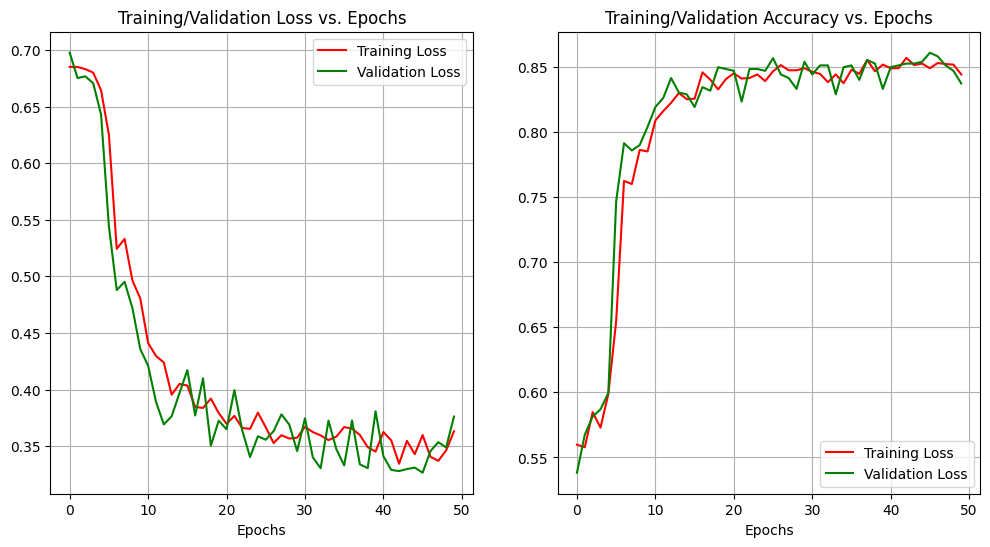

In [34]:
fig, axs = plt.subplots(1,2, figsize = (12,6))

axs[0].plot([epoch for epoch in range(EPOCHS)], train_loss_lst, color = 'r', label = 'Training Loss')
axs[0].plot([epoch for epoch in range(EPOCHS)], val_loss_lst, color = 'g', label = 'Validation Loss')
axs[0].legend()
axs[0].set_title('Training/Validation Loss vs. Epochs')
axs[0].set_xlabel('Epochs')
# axs[0].ylim([0,1])
axs[0].grid(which = 'both')


axs[1].plot([epoch for epoch in range(EPOCHS)], train_acc_lst, color = 'r', label = 'Training Loss')
axs[1].plot([epoch for epoch in range(EPOCHS)], val_acc_lst, color = 'g', label = 'Validation Loss')
axs[1].legend()
axs[1].set_title('Training/Validation Accuracy vs. Epochs')
axs[1].set_xlabel('Epochs')
# axs[1].ylim([0,1])
axs[1].grid(which = 'both')
# plt.savefig('GCNConvTrainingLoss_TestAccuracy.png', dpi=300)
plt.show()